<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 11:

Modelos no-lineales y no-paramétricos

- Procesos gaussianos
- Árboles de regresión bayesianos (BARTs)

Se van a requerir las siguientes librerías en esta clase

In [2]:
import io
import numpy as np
import scipy.stats as st
import scipy.special as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd
import aesara.tensor as at

## Datasets

### Dataset 1: Resistencias de hormigón

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Concrete_Data.csv to Concrete_Data.csv


In [3]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['Concrete_Data.csv']))
df_hormigon['w/c'] = df_hormigon['Water  (kg/m3)']/df_hormigon['Cement (kg/m3)']
df_hormigon.head()

,Cement (kg/m3),Blast Furnace Slag (kg/m3),Fly Ash (kg/m3),Water (kg/m3),Superplasticizer (kg/m3),Coarse Aggregate (kg/m3),Fine Aggregate (kg/m3),Age (day),Concrete compressive strength (MPa),w/c
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0.300000
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0.300000
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0.685714
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0.685714
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0.966767


### Dataset 2: Sintético continuas 

In [4]:
np.random.seed(1234)

n = 50  # The number of data points
x = np.linspace(0, 10, n) # The inputs to the GP must be arranged as a column vector

# Define the true covariance function and its parameters
l_true = 1.0
tau_true = 4.0
cov_func = tau_true**2 * pm.gp.cov.ExpQuad(1, l_true)

# The latent function values are one sample from a multivariate normal
f_true = st.multivariate_normal.rvs( size=1, mean=np.zeros( x.shape[0] ),
                                     cov=cov_func(x[:, None]).eval() )

# The observed data is the latent function plus a small amount of T distributed noise
sigma_true = 1.0
y = f_true + sigma_true * np.random.normal(size=n)

# Guardar en dataframe
df_sint = pd.DataFrame([])
df_sint['x'] = x
df_sint['y'] = y
df_sint['f_true'] = f_true

## Funciones de covarianza

In [5]:
def SEcov( x1, x2, t ):
    """
    Isotropic squared exponential kernel
    k(x,x') = t[0]^2*exp(-1/2/t[1]^2 |x1-x2|^2)

    Args:
        x1: Array of m points (m x d).
        x2: Array of n points (n x d).
        theta: Kernel parameters
            theta[1]: amplitude
            theta[2]: range

    Returns:
        (m x n) matrix
    """
    r2 = np.sum(x1 ** 2, 1).reshape(-1, 1) + np.sum(x2 ** 2, 1) - 2 * np.dot(x1, x2.T)
    return t[0] ** 2 * np.exp(-1/2 / t[1] ** 2 * r2)

def MATcov( x1, x2, t ):
    """
    Isotropic Matern kernel
    k(x,x') = 

    Args:
        x1: Array of m points (m x d).
        x2: Array of n points (n x d).
        theta: Kernel parameters
            theta[0]: amplitude
            theta[1]: range
            theta[2]: shape

    Returns:
        (m x n) matrix
    """
    r2 = np.sum(x1 ** 2, 1).reshape(-1, 1) + np.sum(x2 ** 2, 1) - 2 * np.dot(x1, x2.T)
    r = np.sqrt( r2 )
    aux = np.sqrt(2*t[2])*r/t[1]
    return t[0]**2 * 2**(1-t[2])/sp.gamma(t[2]) * aux**t[2] * sp.kn(t[2],aux)

def POLcov( x1, x2, t ):
    """
    Linear Kernel
    k(x,x') = ( t[0]^2 + x1.T * x2 )^t[1]

    Args:
        x1: Array of m points (m x d).
        x2: Array of n points (n x d).
        theta: Kernel parameters
            theta[1]: amplitude
            theta[2]: polynomial degree

    Returns:
        (m x n) matrix
    """
    A = t[0] ** 2 + x1.dot( x2.T )
    return A**t[1]

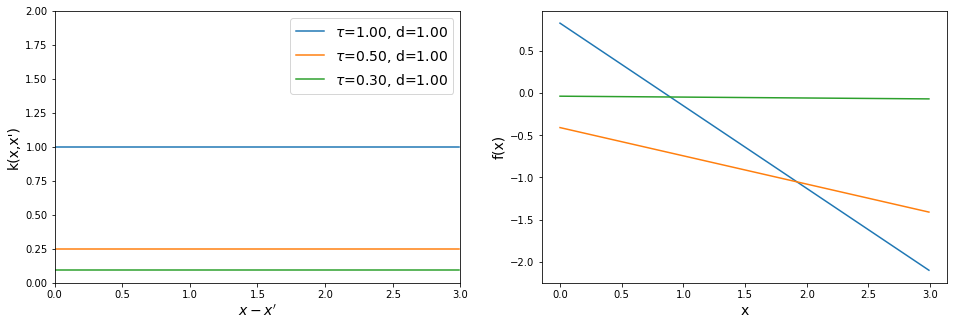

In [6]:
# Gráficos para la clase
np.random.seed(1234)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

xplot = np.arange(0,3,0.01)

# Plotear kernel
t = ( 1, 0.5, 0.3 )
l = ( 1, 1, 1 )
for i in range( len(t) ):
    # Matriz de covarianza
    cov = POLcov( xplot.reshape(-1,1), xplot.reshape(-1,1), [t[i],l[i]] )
    # Plotear función de covarianza
    ax[0].plot( xplot-xplot[0], cov[:,0], label=r'$\tau$={:3.2f}, d={:3.2f}'.format(t[i],l[i]) )
    # Plotear simulación de GP
    ry0 = np.random.multivariate_normal( mean=np.zeros(xplot.shape[0]),
                                         cov=cov, size=1 )
    ax[1].plot( xplot, ry0.T, label=r'$\tau$={:3.2f}, d={:3.2f}'.format(t[i],l[i]) )

ax[0].legend( fontsize=14 )
ax[0].set_xlabel(r"$x-x'$", fontsize=14)
ax[0].set_ylabel("k(x,x')", fontsize=14)
ax[0].set_ylim([0,2])
ax[0].set_xlim([0,3])

# ax[1].set_xlim([0,3])
# ax[1].set_ylim([-2.2,2.2])
ax[1].set_xlabel('x', fontsize=14)
ax[1].set_ylabel('f(x)', fontsize=14);

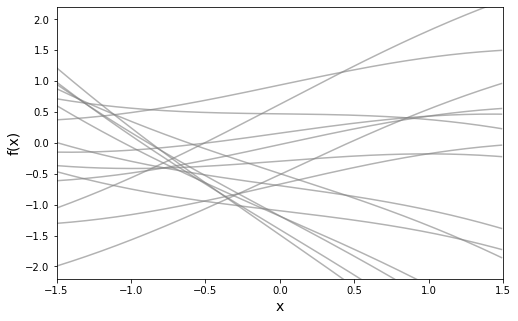

In [7]:
# Gráficos para la clase
np.random.seed(1234)

# Plot
fig, ax = plt.subplots( figsize=(8,5))

xplot = np.arange(-1.5,1.5,0.01)

# Parámetros de la función de covarianza
t, l = 1, 1
# Matriz de covarianza
cov = POLcov( xplot.reshape(-1,1), xplot.reshape(-1,1), [1,1] )
m = lambda x: np.sin(x)*0.4
# Simulaciones de f
rf = np.random.multivariate_normal( mean=m(xplot),
                                    cov=cov, size=1000 )

# Plotear simulaciónes de GP
ax.plot( xplot, rf[:15,:].T, color='gray', alpha=.6 )
# ax.plot( xplot[::10], rf[6,::10], 'C0-o' )

# Plotear intervalos de confianza
fi_qi = np.quantile( rf, [0.05,0.5,0.95], axis=0 )
# ax.plot( xplot, m(xplot), 'k--' )
# ax.fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[2], color='gray', alpha=.2 )


# Plotear distribuciones para un x
ixs = [40,170]
i = 0
yplot = np.arange(-2,2,0.01)

# for i in range(len(ixs)):
#   ax.axvline( xplot[ixs[i]], linestyle='--', color='C'+str(i) )
#   ax.fill_betweenx( y=yplot, x1=xplot[ixs[i]],
#                     x2=xplot[ixs[i]]+st.norm.pdf( yplot, loc=m(xplot[ixs[i]]), scale=0.5*(i+1)),
#                     alpha=.3, color='C'+str(i) )

ax.set_xlim([-1.5,1.5])
ax.set_ylim([-2.2,2.2])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('f(x)', fontsize=14);

## Función de regresión con GP

In [ ]:
def gp_regression( xtrain, ytrain, xtest, theta, sn, cov_func ):

    # Matrices de covarianza
    K = cov_func( xtrain, xtrain, theta ) + sn**2 * np.eye( xtrain.size )
    Kd = cov_func( xtest, xtrain, theta )
    Kdd = cov_func( xtest, xtest, theta )

    # Parámetros de la distribución posterior de f
    f_mean = Kd.dot( np.linalg.solve( K, ytrain ) )
    f_cov = Kdd - Kd.dot( np.linalg.solve( K, Kd.T ) )

    return f_mean, f_cov

## Ejemplo 0: vecinos más cercanos

In [34]:
x = df_sint['x'].to_numpy()
x = (x-x.mean())/x.std()
y = df_sint['y'].to_numpy()
y = (y-y.mean())/y.std()

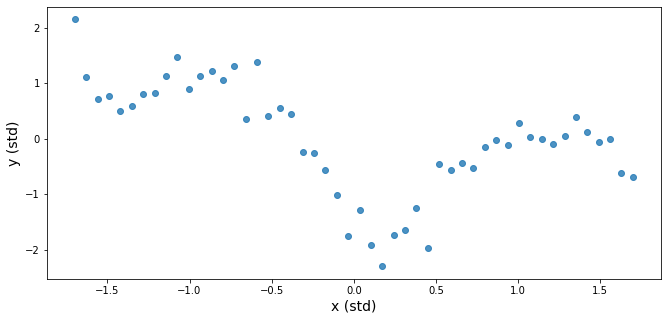

In [35]:
fig, ax = plt.subplots( figsize=(11,5) )
ax.scatter( x, y, alpha=.8 )
ax.set_xlabel('x (std)', fontsize=14)
ax.set_ylabel('y (std)', fontsize=14);

In [44]:
# Implementación sencilla de KNN
def knn( xtrain, ytrain, xtest, k=1 ):

    mu_pred = np.zeros(xtest.size)
    for i in range( xtest.size ):
        di = np.abs( xtrain - xtest[i] )
        ix = list( np.argsort( di )[:k] )
        mu_pred[i] = ytrain[ix].mean()

    return mu_pred

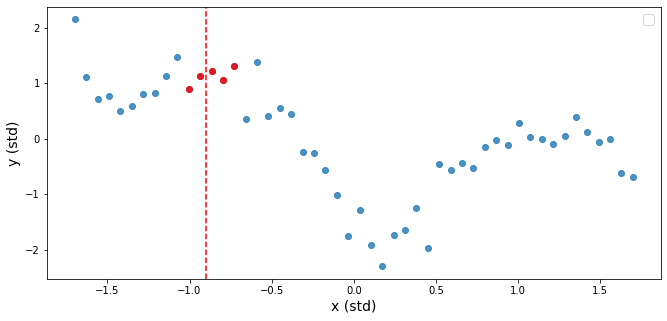

In [68]:
# Gráficos para la clase
xplot = np.arange( -1.5, 1.5, 0.01 )
ks = [5]

fig, ax = plt.subplots( figsize=(11,5) )

for k in ks:

  # Predicciones
  mu_pred = knn( x, y, xplot, k=k )
  # ax.plot( xplot, mu_pred, linestyle='--', label='k={}'.format(str(k)) )

# Colorear x puntual
ix_x = 60
di = np.abs( x - xplot[ix_x] )
ix = list( np.argsort( di )[:k] )
ax.scatter( x[ix], y[ix], alpha=.8, color='r', zorder=10 )
ax.axvline( xplot[ix_x], linestyle='--', color='r' )

# Observaciones
ax.scatter( x, y, alpha=.8 )

ax.set_xlabel('x (std)', fontsize=14)
ax.set_ylabel('y (std)', fontsize=14)
ax.legend( fontsize=14 );

## Ejemplo 1: Resistencia temprana del hormigón

In [71]:
df_ej1 = df_hormigon.query(" `Blast Furnace Slag (kg/m3)` == 0 and `Superplasticizer (kg/m3)` == 0 and `Age (day)` == 3 and `Fly Ash (kg/m3)` == 0 and `Cement (kg/m3)` >= 350" )
df_ej1 = df_ej1.drop_duplicates( 'Cement (kg/m3)' )

x = df_ej1['Cement (kg/m3)'].to_numpy()
x = (x - x.mean())/x.std()
y = df_ej1['Concrete compressive strength (MPa) '].to_numpy()
y = (y - y.mean())/y.std()

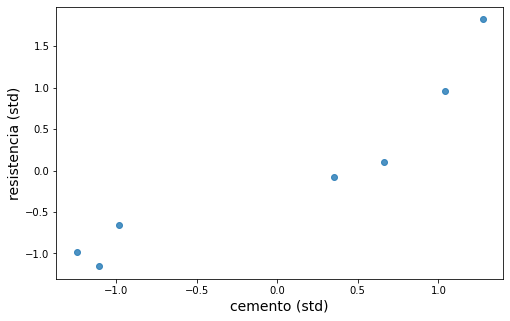

In [72]:
fig, ax = plt.subplots( figsize=(8,5) )

ax.scatter( x, y, alpha=.8 )
ax.set_xlabel('cemento (std)', fontsize=14)
ax.set_ylabel('resistencia (std)', fontsize=14);

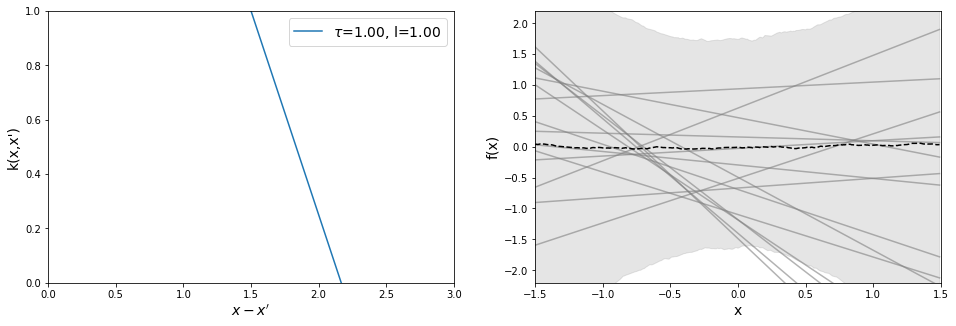

In [10]:
## Gráficos para la clase
np.random.seed(1234)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

xplot = np.arange(-1.5,1.5,0.01)

# Parámetros de la función de covarianza
t, l = 1, 1
# Matriz de covarianza
cov = SEcov( xplot.reshape(-1,1), xplot.reshape(-1,1), [1,1] )
# Simulaciones a priori de f
rf_priori = np.random.multivariate_normal( mean=np.zeros(xplot.shape[0]),
                                           cov=cov, size=1000 )

# Plotear función de covarianza
ax[0].plot( xplot-xplot[0], cov[:,0],
            label=r'$\tau$={:3.2f}, l={:3.2f}'.format(t,l) )

ax[0].legend( fontsize=14 )
ax[0].set_xlabel(r"$x-x'$", fontsize=14)
ax[0].set_ylabel("k(x,x')", fontsize=14)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,3])

# Plotear simulación de GP
ax[1].plot( xplot, rf_priori[:15,:].T, color='gray', alpha=.6 )
fi_qi = np.quantile( rf_priori, [0.05,0.5,0.95], axis=0 )
ax[1].plot( xplot, fi_qi[1], 'k--' )
ax[1].fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[2], color='gray', alpha=.2 )

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-2.2,2.2])
ax[1].set_xlabel('x', fontsize=14)
ax[1].set_ylabel('f(x)', fontsize=14);

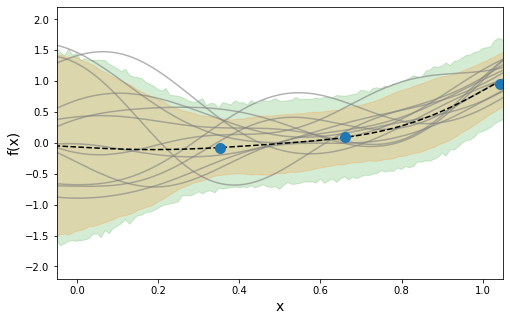

In [11]:
## Gráficos para la clase
np.random.seed(5342)
xplot = np.arange(-0.5,1.5,0.01)

# Regresión GP para un subconjunto de las observaciones
theta = [1,0.3]
sn = 0.3
f_mean, f_cov = gp_regression( x.reshape(-1,1), y,
                               xplot.reshape(-1,1), theta, sn,
                               SEcov )

# Ploteo
fig, ax = plt.subplots( figsize=(8,5))


# Simulaciones de f
rf = np.random.multivariate_normal( mean=f_mean, cov=f_cov, size=1000 )
ry = np.random.multivariate_normal( mean=f_mean, cov=f_cov+sn**2*np.eye(f_mean.size), size=1000 )

# Realizaciones
ax.plot( xplot, rf[:12,:].T, color='gray', alpha=.6 )

# Intervalos de confianza
f_mean = rf.mean(axis=0)
ax.plot( xplot, f_mean, 'k--')
fi_qi = np.quantile( rf, [0.05,0.95], axis=0 )
yi_qi = np.quantile( ry, [0.05,0.95], axis=0 )
ax.fill_between( x=xplot, y1=yi_qi[0], y2=yi_qi[1], color='C2', alpha=.2 )
ax.fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[1], color='C1', alpha=.2 )

# Distribución posterior
ixs = [85,116,154]
# for i in range(len(ixs)):
#     ax.axvline( xplot[ixs[i]], linestyle='--', color='C0' )
#     ax.fill_betweenx( y=yplot, x1=xplot[ixs[i]],
#                       x2=xplot[ixs[i]]+0.2*st.norm.pdf( yplot, loc=f_mean[ixs[i]],
#                                                         scale=0.3),
#                       alpha=.3, color='C0' )

# ax.axvline( xplot[100], linestyle='--', color='C1' )
# ax.fill_betweenx( y=yplot, x1=xplot[100],
#                   x2=xplot[100]+0.2*st.norm.pdf( yplot, loc=f_mean[100],
#                                                     scale=0.3),
#                   alpha=.3, color='C1' )
# ax.fill_betweenx( y=yplot, x1=xplot[100],
#                   x2=xplot[100]+0.2*st.norm.pdf( yplot, loc=f_mean[100],
#                                                     scale=0.5),
#                   alpha=.3, color='C2' )

# Observaciones
ax.plot( x, y, 'C0o', markersize=10 )

ax.set_xlim([-0.05,1.05])
ax.set_ylim([-2.2,2.2])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('f(x)', fontsize=14);

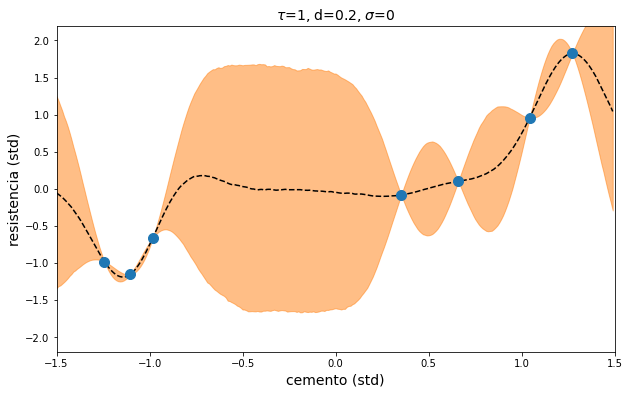

In [75]:
## Gráficos para la clase
np.random.seed(5342)

# Regresión GP para un subconjunto de las observaciones
theta = [1,0.2]
sn = 0
f_mean, f_cov = gp_regression( x.reshape(-1,1), y,
                               xplot.reshape(-1,1), theta, sn,
                               SEcov )

# Simulaciones posteriores de f
Nsim = 5000
rf = st.multivariate_normal.rvs( size=Nsim, mean=f_mean, cov=f_cov )

# Simulaciones posteriores predictivas de y
ry = st.multivariate_normal.rvs( size=Nsim, mean=f_mean,
                                 cov=f_cov + sn**2*np.eye(xplot.size) )

# Ploteo
fig, ax = plt.subplots( figsize=(10,6) )

# Realizaciones
# ax.plot( xplot, rf[:12,:].T, color='C1', alpha=.6 )

# Intervalos de confianza posteriores de f
yi_qi = np.quantile( ry, [0.05,0.5,0.95], axis=0 )
# ax.fill_between( x=xplot, y1=yi_qi[0], y2=yi_qi[2], color='C2', alpha=.5 )

# Intervalos de confianza posteriores de y
fi_qi = np.quantile( rf, [0.05,0.5,0.95], axis=0 )
ax.plot( xplot, fi_qi[1], 'k--' )
ax.fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[2], color='C1', alpha=.5 )

# Observaciones
ax.plot( x, y, 'C0o', markersize=10 )

ax.set_xlabel('cemento (std)', fontsize=14)
ax.set_xlim([-1.5,1.5])
ax.set_ylabel('resistencia (std)', fontsize=14)
ax.set_ylim([-2.2,2.2])
ax.set_title(r'$\tau$={}, d={}, $\sigma$=0'.format(theta[0], theta[1]), fontsize=14);

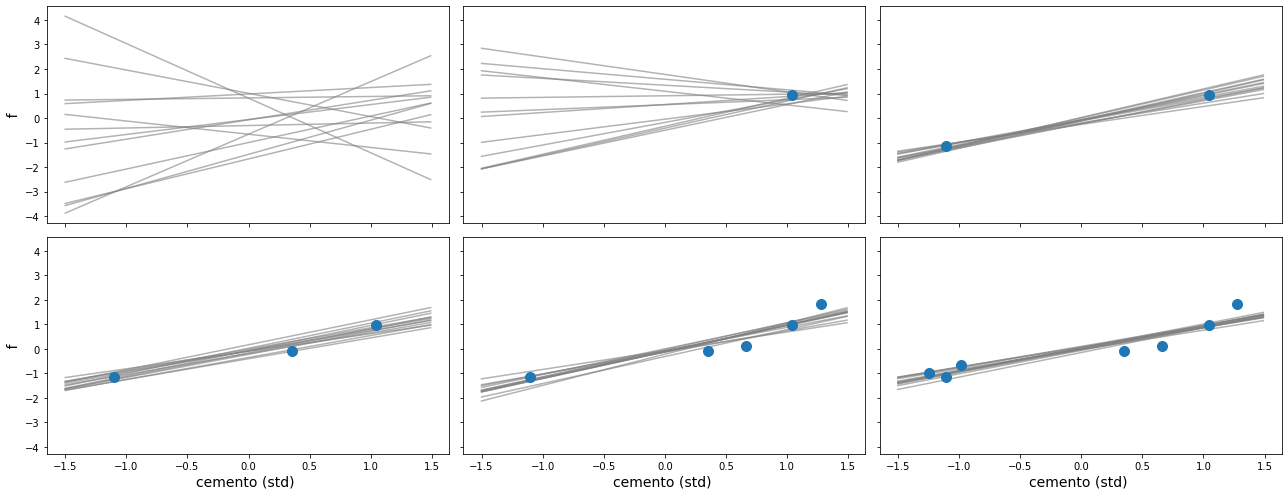

In [33]:
## Gráficos para la clase

# Regresión GP para un subconjunto de las observaciones
theta = [1,1]
sn = 0.2
ixs = [6,4,2,3,5,0,1]
ss = [0,1,2,3,5,7]
xplot = np.arange(-1.5,1.5,0.01)

# Ploteo
fig, ax = plt.subplots( figsize=(18,7), nrows=2, ncols=3,
                        sharex=True, sharey=True )

for i in range( len(ss) ):

    row = i//3
    col = i - 3*row

    # Regresión GP
    f_mean, f_cov = gp_regression( x[ixs[:ss[i]]].reshape(-1,1), y[ixs[:ss[i]]],
                                   xplot.reshape(-1,1), theta, sn,
                                   POLcov )

    # Simulaciones posteriores de f
    Nsim = 5000
    rf = st.multivariate_normal.rvs( size=Nsim, mean=f_mean, cov=f_cov )

    # Realizaciones
    ax[row, col].plot( xplot, rf[:12,:].T, color='gray', alpha=.6 )

    # Intervalos de confianza posteriores de f
    fi_qi = np.quantile( rf, [0.05,0.5,0.95], axis=0 )
    # ax[row,col].plot( xplot, fi_qi[1], 'k--' )
    # ax[row, col].fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[2], color='gray',
    #                            alpha=.3 )

    # Observaciones
    ax[row, col].plot( x[ixs[:ss[i]]], y[ixs[:ss[i]]], 'C0o', markersize=10 )

    if col==0:
      ax[row,col].set_ylabel(' f ', fontsize=14)
    if row==1:
      ax[row,col].set_xlabel( 'cemento (std) ', fontsize=14)

fig.set_tight_layout(True)

### regresión con PYMC

In [15]:
with pm.Model() as model_11:

    # Prioris
    tau = pm.HalfNormal("tau", sigma=1)
    l = pm.Gamma("l", alpha=2, beta=1)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau**2 * pm.gp.cov.ExpQuad( 1, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x.reshape(-1,1))

    # Verosimilitud
    y_ = pm.Normal( "y", mu=f, sigma=sigma, observed=y )

    # Simulación posterior de f
    trace_11 = pm.sample( 1000, tune=2000, cores=2 )

ERROR:pymc:There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


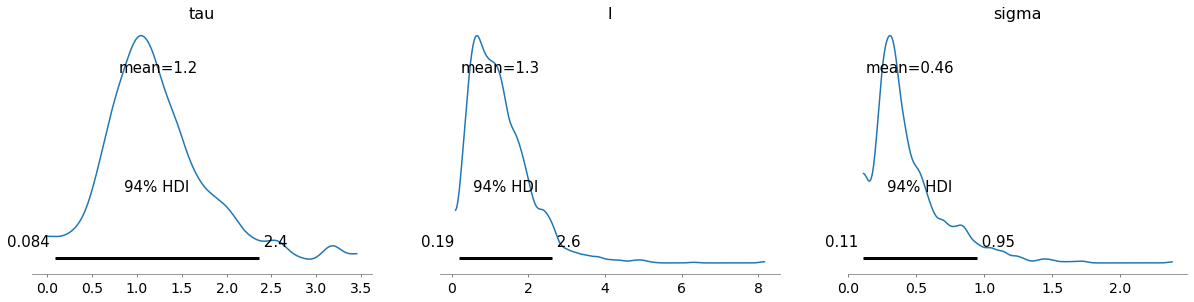

In [16]:
az.plot_posterior( trace_11, var_names=['tau','l','sigma'] );

In [17]:
# Predicciones posteriores en xtest para plotear mejor
xtest = np.arange(-1.5,1.5,0.05)
with model_11:
    # Predicciones posteriores en xtest
    f_pred = gp.conditional( "f_test", xtest.reshape(-1,1), jitter=1e-4 )

    # Prediccion posterior predictiva
    pm.sample_posterior_predictive( trace_11, var_names=["f_test"],
                                    extend_inferencedata=True )

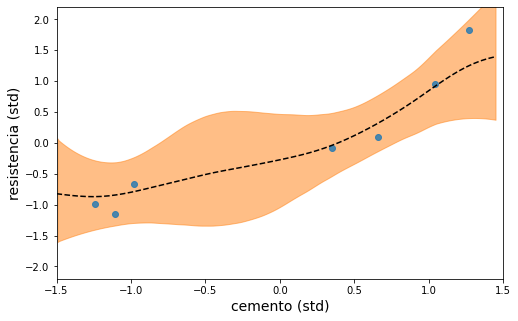

In [18]:
fig, ax = plt.subplots( figsize=(8,5) )

# Regresión GP
ax.plot( xtest, trace_11.posterior_predictive['f_test'].mean(['chain','draw']),
         'k--', label=r'$\overline{f}$')
az.plot_hdi( xtest, trace_11.posterior_predictive['f_test'], hdi_prob=0.9 )

# Observaciones
ax.scatter( x, y, alpha=.8 )

ax.set_xlabel('cemento (std)', fontsize=14)
ax.set_xlim([-1.5,1.5])
ax.set_ylabel('resistencia (std)', fontsize=14)
ax.set_ylim([-2.2,2.2]);

## Ejemplo 2: regresión con GPs en dataset sintético

In [19]:
x = df_sint['x'].to_numpy()
x = (x-x.mean())/x.std()
y = df_sint['y'].to_numpy()
y = (y-y.mean())/y.std()

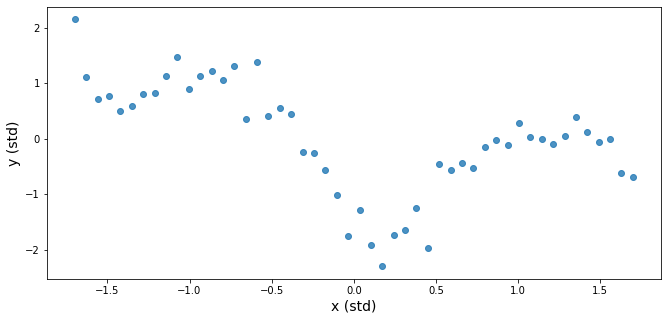

In [20]:
fig, ax = plt.subplots( figsize=(11,5) )
ax.scatter( x, y, alpha=.8 )
ax.set_xlabel('x (std)', fontsize=14)
ax.set_ylabel('y (std)', fontsize=14);

In [21]:
with pm.Model() as model_21:

    # Prioris
    tau = pm.Exponential("tau", lam=1)
    l = pm.Exponential("l", lam=1)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau**2 * pm.gp.cov.ExpQuad( 1, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x.reshape(-1,1))

    # Verosimilitud
    y_ = pm.Normal( "y", mu=f, sigma=sigma, observed=y )

    # Simulación posterior de f
    trace_21 = pm.sample( 1000, tune=2000, cores=2 )

ERROR:pymc:There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 93 divergences after tuning. Increase `target_accept` or reparameterize.


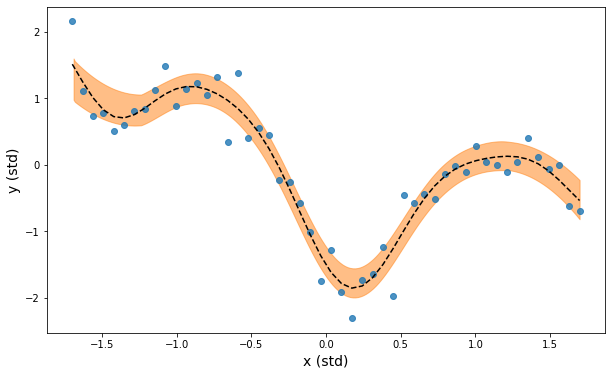

In [22]:
fig, ax = plt.subplots( figsize=(10,6) )

# Regresión GP
ix = np.argsort( x )
ax.plot( x, trace_21.posterior['f'].mean(['chain','draw']),
         'k--', label=r'$\overline{f}$')
az.plot_hdi( x, trace_21.posterior['f'], hdi_prob=0.9 )

# Observaciones
ax.scatter( x, y, alpha=.8 )
ax.set_xlabel('x (std)', fontsize=14)
ax.set_ylabel('y (std)', fontsize=14);

### Ajustes de regresión lineal con splines

In [23]:
# Funciones splines para ajuste
def bspline(x, k, i, t):
   if k == 0:
      return 1.0*( np.logical_and(x>=t[i],x<t[i+1]) ) + 0
      # return 1.0 if t[i] <= x < t[i+1] else 0.0
   if t[i+k] == t[i]:
      c1 = 0.0
   else:
      c1 = (x - t[i])/(t[i+k] - t[i]) * bspline(x, k-1, i, t)
   if t[i+k+1] == t[i+1]:
      c2 = 0.0
   else:
      c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * bspline(x, k-1, i+1, t)
   return c1 + c2

def Bspline( x, i, knots, degree=3 ):
    knots_ext = degree*[knots[0]] + knots + degree*[knots[-1]]
    return bspline( x, degree, i, knots_ext )

In [24]:
degree = 3
knots = list( np.linspace( x.min(), x.max(), 6) )
Nk = len(knots)
with pm.Model() as model_2b6:

    # Data container
    # B = pm.math.stack([X**(i+1) for i in range(degree)])
    B = pm.math.stack([Bspline( x, i, knots, degree) for i in range(Nk+degree-1)])

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=Nk+degree-1 )
    sigma = pm.Exponential("sigma", 1)

    # Verosimilitud
    mu = pm.Deterministic( 'mu', alpha + pm.math.dot( B.T, beta ) )
    pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
    
    # Posterior
    trace_2b6 = pm.sample( 3000, tune=1000, cores=2 )

In [ ]:
degree = 3
knots = list( np.linspace( x.min(), x.max(), 10) )
Nk = len(knots)
with pm.Model() as model_2b10:

    # Data container
    # B = pm.math.stack([X**(i+1) for i in range(degree)])
    B = pm.math.stack([Bspline( x, i, knots, degree) for i in range(Nk+degree-1)])

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=Nk+degree-1 )
    sigma = pm.Exponential("sigma", 1)

    # Verosimilitud
    mu = pm.Deterministic( 'mu', alpha + pm.math.dot( B.T, beta ) )
    pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
    
    # Posterior
    trace_2b10 = pm.sample( 3000, tune=1000, cores=2 )

In [ ]:
degree = 3
knots = list( np.linspace( x.min(), x.max(), 14) )
Nk = len(knots)
with pm.Model() as model_2b14:

    # Data container
    # B = pm.math.stack([X**(i+1) for i in range(degree)])
    B = pm.math.stack([Bspline( x, i, knots, degree) for i in range(Nk+degree-1)])

    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=Nk+degree-1 )
    sigma = pm.Exponential("sigma", 1)

    # Verosimilitud
    mu = pm.Deterministic( 'mu', alpha + pm.math.dot( B.T, beta ) )
    pm.Normal( "y", mu=mu, sigma=sigma, observed=y )
    
    # Posterior
    trace_2b14 = pm.sample( 3000, tune=1000, cores=2 )

In [ ]:
fig, ax = plt.subplots( figsize=(10,6) )

# Regresión GP
ix = np.argsort( x )
ax.plot( x[ix], trace_2b14.posterior['mu'].mean(['chain','draw'])[ix],
         'k--', label=r'$\overline{f}$')
az.plot_hdi( x, trace_2b14.posterior['mu'][:,:,ix], hdi_prob=0.9 )

# Observaciones
ax.scatter( x, y, alpha=.8 )
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

### Comparación de modelos

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:813: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distrib

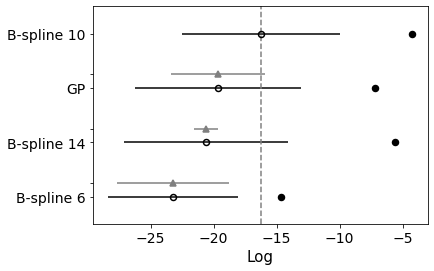

In [28]:
models_list = {'GP':trace_21,'B-spline 6':trace_2b6,
               'B-spline 10':trace_2b10,'B-spline 14':trace_2b14}
models_comp = az.compare( models_list )
az.plot_compare( models_comp );

## Ejemplo 3: Regresión logística con GPs

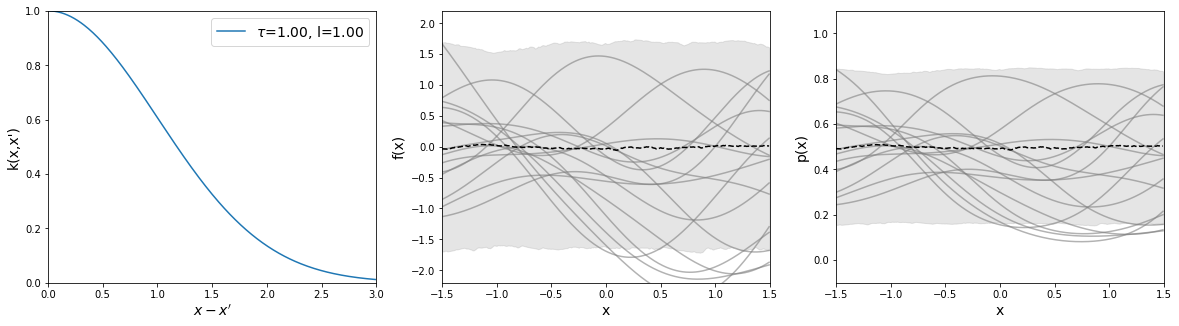

In [ ]:
## Gráficos para la clase
np.random.seed(1234)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

xplot = np.arange(-1.5,1.5,0.01)

# Parámetros de la función de covarianza
t, l = 1, 1
# Matriz de covarianza
cov = SEcov( xplot.reshape(-1,1), xplot.reshape(-1,1), [1,1] )
# Simulaciones de f
rf = np.random.multivariate_normal( mean=np.zeros(xplot.shape[0]),
                                     cov=cov, size=1000 )
rq = sp.expit(rf)

# Plotear función de covarianza
ax[0].plot( xplot-xplot[0], cov[:,0],
            label=r'$\tau$={:3.2f}, l={:3.2f}'.format(t,l) )

ax[0].legend( fontsize=14 )
ax[0].set_xlabel(r"$x-x'$", fontsize=14)
ax[0].set_ylabel("k(x,x')", fontsize=14)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,3])

# Plotear simulación de f
ax[1].plot( xplot, rf[:15,:].T, color='gray', alpha=.6 )
fi_qi = np.quantile( rf, [0.05,0.5,0.95], axis=0 )
ax[1].plot( xplot, fi_qi[1], 'k--' )
ax[1].fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[2], color='gray', alpha=.2 )

ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-2.2,2.2])
ax[1].set_xlabel('x', fontsize=14)
ax[1].set_ylabel('f(x)', fontsize=14);

# Plotear simulación de p
ax[2].plot( xplot, rq[:15,:].T, color='gray', alpha=.6 )
fi_qi = np.quantile( rq, [0.05,0.5,0.95], axis=0 )
ax[2].plot( xplot, fi_qi[1], 'k--' )
ax[2].fill_between( x=xplot, y1=fi_qi[0], y2=fi_qi[2], color='gray', alpha=.2 )

ax[2].set_xlim([-1.5,1.5])
ax[2].set_ylim([-0.1,1.1])
ax[2].set_xlabel('x', fontsize=14)
ax[2].set_ylabel('p(x)', fontsize=14);

### Dataset sintético binario

In [ ]:
# Dataset sintético
np.random.seed(1234)
N = 100
x1 = st.uniform.rvs( loc=-2, scale=4, size=N )
x2 = st.uniform.rvs( loc=-2, scale=4, size=N )
logitp = lambda x1, x2: 0.1 + 2.5*x1 + 1*x2 + 1.2*x2**2
p = 1 / (1+np.exp(-logitp(x1,x2)))
y = st.binom.rvs( 1, p, size=N )

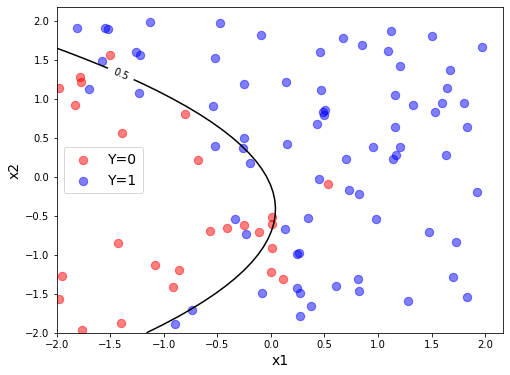

In [ ]:
# Ploteo de observaciones
coords = np.arange(-2,2,0.1)
x1test, x2test = np.meshgrid( coords, coords )
logitp_test = logitp( x1test, x2test )

fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# p=0.5 curva real
CS = ax.contour( x1test, x2test, 1/(1+np.exp(-logitp_test)), [0.5], colors='k' )
ax.clabel( CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );

### Regresión solo con x1

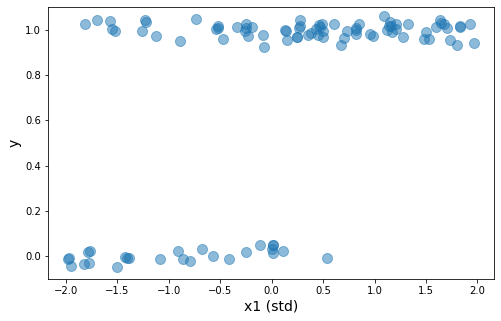

In [ ]:
# Plote de observaciones y vs x1
fig, ax = plt.subplots( figsize=(8,5) )

# Observaciones
ax.scatter( x1, y/1 + st.norm.rvs(size=y.size,scale=0.03), alpha=.5, s=100 )

# Formateo
ax.set_xlabel('x1 (std)', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_ylim([-0.1,1.1]);

In [ ]:
# Modelo logístico lineal
with pm.Model() as model_40:

    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*x1 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Bernoulli( "y", p=p, observed=y )

    # Posterior de los parámetros
    trace_40 = pm.sample( 3000, tune=2000, cores=2 )

In [ ]:
# Modelo logístico con GP
with pm.Model() as model_41:

    # Prioris
    tau = pm.Exponential("tau", lam=1.0)
    l = pm.InverseGamma("l", mu=1.0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau**2 * pm.gp.cov.ExpQuad( 1, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x1.reshape(-1,1))

    # Verosimilitud
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)

    trace_41 = pm.sample( 1000, tune=2000, cores=2 )

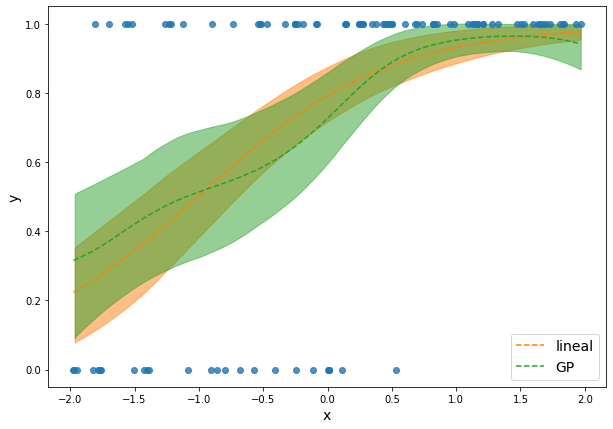

In [ ]:
fig, ax = plt.subplots( figsize=(10,7) )

# Regresión logística lineal
ix = np.argsort( x1 )
ax.plot( x1[ix], trace_40.posterior['p'].mean(['chain','draw'])[ix],
         'C1--', label='lineal')
az.plot_hdi( x1[ix], trace_40.posterior['p'][:,:,ix], hdi_prob=0.9, color='C1')

# Regresión logística con GP
ix = np.argsort( x1 )
ax.plot( x1[ix], trace_41.posterior['p'].mean(['chain','draw'])[ix],
         'C2--', label=r'GP')
az.plot_hdi( x1[ix], trace_41.posterior['p'][:,:,ix], hdi_prob=0.9, color='C2')

# Observaciones
ax.scatter( x1, y, alpha=.8 )
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.legend( fontsize=14 );

## Procesos Gaussianos en 2D

In [78]:
# Dataset sintético
np.random.seed(1234)

# grid para plotear
dx = np.arange(-2,2,0.1)
x1grid, x2grid = np.meshgrid( dx, dx )
x12grid = np.stack([x1grid.flatten(),x2grid.flatten()]).T

K = SEcov( x12grid, x12grid, [1,1] )

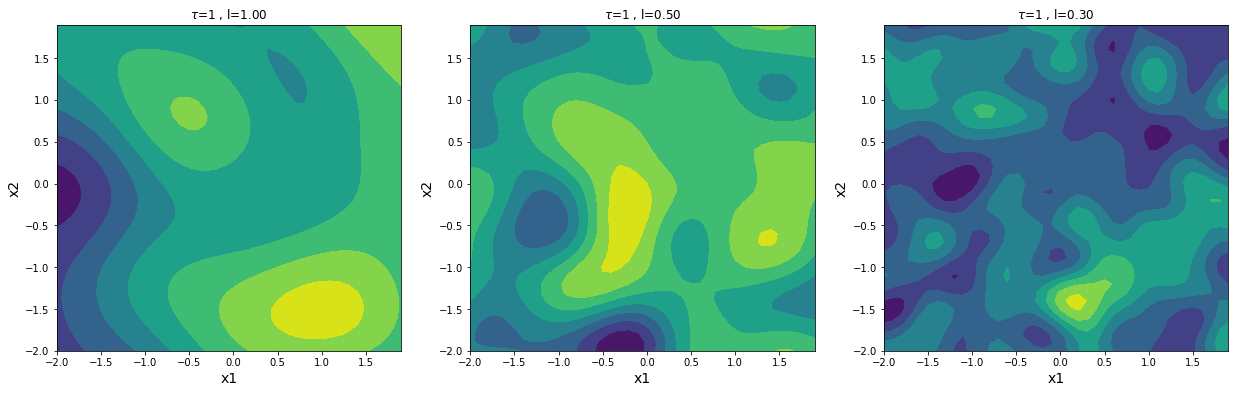

In [79]:
# Simulaciones de f
K = SEcov( x12grid, x12grid, [1,1] )
rf = np.random.multivariate_normal( mean=np.zeros(x12grid.shape[0]), cov=K, size=1 )
rf = rf.reshape(-1,40,40)

# Plot
fig, ax = plt.subplots( figsize=(21,6), ncols=3 )

ls = [1,0.5,0.3] 
for i in range(3):
    # Simulaciones de f
    K = SEcov( x12grid, x12grid, [1,ls[i]] )
    rf = np.random.multivariate_normal( mean=np.zeros(x12grid.shape[0]), cov=K, size=1 )
    rf = rf.reshape(-1,40,40)

    ax[i].contourf( x1grid, x2grid, rf[0,:,:] )

    ax[i].set_xlim([-2,1.9])
    ax[i].set_ylim([-2,1.9])
    ax[i].set_xlabel('x1', fontsize=14)
    ax[i].set_ylabel('x2', fontsize=14)
    ax[i].set_title(r'$\tau$=1 , l={:3.2f}'.format(ls[i]));

## Ejemplo 4: regresión binaria con x1 y x2

In [ ]:
# Modelo logístico lineal
with pm.Model() as model_42:

    X1 = pm.MutableData( 'X1', x1 )
    X2 = pm.MutableData( 'X2', x2 )
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 + beta2*X2 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=1, p=p, observed=y )

    # Posterior de los parámetros
    trace_42 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_42, extend_inferencedata=True )

In [ ]:
# Predicciones para xtest solo para plotear mejor
coords = np.arange(-2,2,0.1)
x1test, x2test = np.meshgrid( coords, coords )
with model_42:
    # Posterior predictiva de y
    pm.set_data( {'X1':x1test.flatten(), 'X2':x2test.flatten()} )
    ppc_plot = pm.sample_posterior_predictive( trace_42, var_names=['p'] )

In [ ]:
# Modelo con GPs
x12 = np.vstack([x1,x2]).T # Poner en forma de vector de N x d

with pm.Model() as model_43:

    # Prioris
    tau = pm.Exponential("tau", lam=1.0)
    l = pm.InverseGamma("l", mu=1.0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau**2 * pm.gp.cov.ExpQuad( 2, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x12)

    # Verosimilitud
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)

    trace_43 = pm.sample( 1000, tune=2000, cores=2 )

In [ ]:
# Predicciones posteriores en xtest para plotear mejor
x12test = np.stack([x1test.flatten(),x2test.flatten()]).T
with model_43:
    f_pred = gp.conditional("f_test", x12test, jitter=1e-4)
    p_pred = pm.Deterministic("p_test", pm.math.invlogit(f_pred))

    ppc = pm.sample_posterior_predictive( trace_43.posterior,
                                          var_names=["f_test", "p_test"])
    trace_43.extend(ppc)

In [ ]:
# Modelo logístico lineal con término cuadrático
with pm.Model() as model_44:

    X1 = pm.MutableData( 'X1', x1 )
    X2 = pm.MutableData( 'X2', x2 )
    
    # Priors
    beta0 = pm.Normal( "beta0", mu=0, sigma=1.5 )
    beta1 = pm.Normal( "beta1", mu=0, sigma=1.5 )
    beta2 = pm.Normal( "beta2", mu=0, sigma=1.5 )
    beta3 = pm.Normal( "beta3", mu=0, sigma=1.5 )
    
    # Mean
    logitp = pm.Deterministic( "logitp", beta0 + beta1*X1 + beta2*X2 + beta3*X2**2 )
    p = pm.Deterministic( "p", pm.math.invlogit(logitp) )
    
    # Modelo
    Y = pm.Binomial( "y", n=1, p=p, observed=y )

    # Posterior de los parámetros
    trace_44 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_44, extend_inferencedata=True )

### Comparación de modelos

In [ ]:
models_list = {'y ~ x1':trace_40, 'y ~ GP(x1)':trace_41,
               'y ~ x1 + x2':trace_42, 'y ~ GP(x1,x2)':trace_43,
               'y ~ x1 + x2 + x2^2':trace_44}
models_comp = az.compare( models_list )

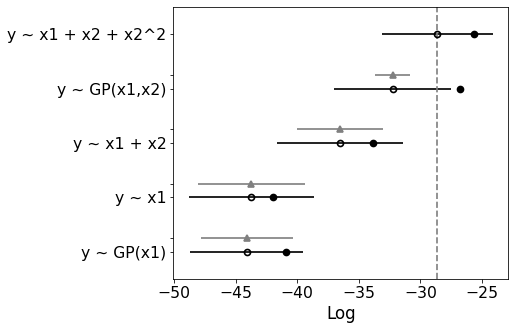

In [ ]:
az.plot_compare( models_comp )

## Ejemplo 5: Regresión logística con GP

In [76]:
# Dataset sintético
np.random.seed(1234)
N = 100
x1 = st.uniform.rvs( loc=-2, scale=4, size=N )
x2 = st.uniform.rvs( loc=-2, scale=4, size=N )
x12 = np.vstack([x1,x2]).T

f_true = lambda x1, x2: 0.2*(x1**2+x2**2) - 0.4
y_true = f_true(x1,x2) + st.norm.rvs( size=x1.size, scale=0.1 )
y = 1*(y_true>0)

# grid para plotear
dx = np.arange(-2,2,0.1)
x1grid, x2grid = np.meshgrid( dx, dx )
x12grid = np.stack([x1grid.flatten(),x2grid.flatten()]).T

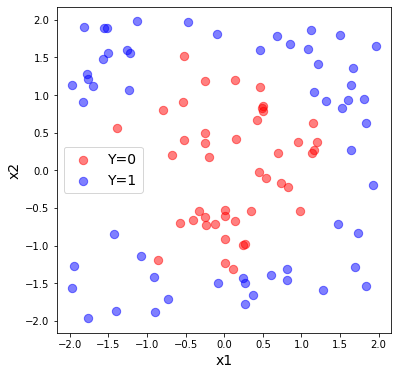

In [77]:
# Ploteo de curva p=0.5
fig, ax = plt.subplots( figsize=(6,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# CS = ax.contour( x1grid, x2grid, f_true(x1grid,x2grid), colors='k' )
# ax.clabel(CS, inline=True, fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );

In [ ]:
# Regresión logística con GPs
x12 = np.hstack([x1[:,None],x2[:,None]])

with pm.Model() as model_51:

    # Prioris
    tau = pm.Exponential("tau", lam=1.0)
    l = pm.InverseGamma("l", mu=1.0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    cov = tau**2 * pm.gp.cov.ExpQuad( 2, l )
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x12)

    # Verosimilitud
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)

    trace_51 = pm.sample( 1000, tune=2000, cores=2 )

In [ ]:
# Predicciones posteriores en xtest para plotear mejor
dx = np.arange(-2,2,0.2)
x1test, x2test = np.meshgrid( dx, dx )
x12test = np.stack([x1test.flatten(),x2test.flatten()]).T
with model_51:
    f_pred = gp.conditional("f_test", x12test, jitter=1e-4)
    p_pred = pm.Deterministic("p_test", pm.math.invlogit(f_pred))

    ppc = pm.sample_posterior_predictive( trace_51.posterior,
                                          var_names=["f_test", "p_test"])
    trace_51.extend(ppc)

In [ ]:
# Ploteo de curva p=0.5
fig, ax = plt.subplots( figsize=(8,6) )

# Observaciones
ax.scatter( x1[y==0], x2[y==0], c='r', label='Y=0', s=70, alpha=.5 )
ax.scatter( x1[y==1], x2[y==1], c='b', label='Y=1', s=70, alpha=.5 )

# p media
p_mean = trace_51.posterior_predictive['p_test'].mean(['chain','draw']).values
CS = ax.contour( x1test, x2test, p_mean.reshape(20,20), [0.5], colors='k' )
ax.clabel( CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)

# Formateo
ax.set_xlabel('x1', fontsize=14)
ax.set_ylabel('x2', fontsize=14)
ax.legend( fontsize=14 );